# All the parameters that need to be changed

In [2]:
# Hawaii
state_ab = "hi"

## Data
1. Download all the data in directory "il_data"
2. Eextract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/Congressional_Final_2022.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/hi_sldu_adopted_2022.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/hi_sldl_adopted_2022.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

## Parameters that needs to be manually checked

### base vest data
start_col = 5\
vest_base_data = vest20\
year = '20'

### district data
district column name of cong_df, send, hdist when calling add_dist()

# Program starts

In [7]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import os

maup.progress.enabled = True

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [10]:
def add_district(dist_df, dist_name, election_df, col_name):
    # Commenting out crs changes b/c we had issues with this state
    #election_df = election_df.to_crs(election_df.estimate_utm_crs())
    #dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [11]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [12]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [13]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    # Commenting out crs changes b/c we had issues with this state
    #df = df.to_crs(df.estimate_utm_crs())
    #vest = vest.to_crs(vest.estimate_utm_crs())
    #population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [14]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    # Removed below b/c otherwise there were crs utm issues
    #vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        #county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [15]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

## Read the census data

In [17]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [18]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [19]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

In [23]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 1328.07it/s]


True

# Read the base vest data
Now using it as a "base precinct", but it could be vest 18 or vest 16 if vest 20 is not working

### Check if vest 20 can be used as base

In [26]:
vest20 = gpd.read_file(vest20_data)

### If it is true for maup doctor, we will use it as the base vest data.
Check where the election column starts, this should be the same for all vest data in that state

In [28]:
vest20.columns

Index(['COUNTYFP', 'STATEFP', 'PRECINCT', 'GEOID', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREOPIE', 'geometry'],
      dtype='object')

## Parameters that need to be checked

We had to be extra careful with the crs's for this state

In [30]:
start_col = 4
year = '20'

In [31]:
vest20 = vest20.to_crs(vest20.estimate_utm_crs())

In [32]:
vest20 = vest20.to_crs(county_df.crs)
vest_base_data = vest20

In [33]:
county_df.crs

<Projected CRS: EPSG:32603>
Name: WGS 84 / UTM zone 3N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 168°W and 162°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-168.0, 0.0, -162.0, 84.0)
Coordinate Operation:
- name: UTM zone 3N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
vest_base_data.crs

<Projected CRS: EPSG:32603>
Name: WGS 84 / UTM zone 3N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 168°W and 162°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-168.0, 0.0, -162.0, 84.0)
Coordinate Operation:
- name: UTM zone 3N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 2084.23it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 846.99it/s]


Identifying overlaps...


100%|███████████████████████████████████████| 395/395 [00:00<00:00, 2457.90it/s]


Resolving overlaps and filling gaps...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 852.81it/s]


1 gaps in region 0 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 0: 100%|█████████████| 49/49 [00:00<00:00, 79.86it/s]
Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 1: 100%|██████████████| 1/1 [00:00<00:00, 265.13it/s]


Found a component of the region at index 1 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


3 gaps in region 2 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 2: 100%|███████████████████| 1/1 [00:00<00:00, 20.29it/s]


1 gaps in region 3 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 4 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 4: 100%|████████████| 12/12 [00:00<00:00, 189.53it/s]


Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.
Found a component of the region at index 4 that does not intersect any geometry assigned to that region.


Gaps to fill in region 4: 100%|███████████████████| 2/2 [00:00<00:00, 97.40it/s]


In [36]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:500])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13173783601089376, 0.13173783601089376, 8.88224937940034, 8.88224937940034, 9.334727544666022, 9.334727544666022, 12.130296851457372, 12.130296851457372, 18.12358440642744, 18.12358440642744, 29.560504825311675, 29.56050482531168, 32.39755784662127, 32.39755784662127, 41.83260522596468, 41.83260522596468, 46.523249535668214, 46.523249535668214, 48.2649353

In [37]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 269/269 [00:00<00:00, 3977.89it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████| 262/262 [00:00<00:00, 1049.97it/s]


In [38]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 262/262 [00:00<00:00, 1042.09it/s]


True

Now we need to switch the crs back . . .

In [40]:
vest_base = vest_base.to_crs(population_df.crs)

In [41]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 262/262 [00:01<00:00, 231.63it/s]


In [42]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [43]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [44]:
election_df = gpd.GeoDataFrame(vest_base)

### Check if the population agrees

In [46]:
check_population(population_df, vest_base)

population agrees


# Add more vest data
We adjusted the crs here b/c we had two common utm crs's for Hawaii and needed to just pick one.

In [48]:
vest18 = gpd.read_file(vest18_data)

In [49]:
vest18.columns

Index(['COUNTY', 'PRECINCT', 'G18USSDHIR', 'G18USSRCUR', 'G18GOVDIGE',
       'G18GOVRTUP', 'G18GOVGBRE', 'G18GOVITER', 'geometry'],
      dtype='object')

In [50]:
vest18 = vest18.to_crs(election_df.crs)

In [51]:
# check the result here
start_col = 2
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 262/262 [00:00<00:00, 1038.87it/s]


There are 4 overlaps.
There are 3 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 276/276 [00:00<00:00, 4049.35it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 262/262 [00:01<00:00, 222.49it/s]


population agrees


### vest 16
We adjusted the crs here b/c we had two common utm crs's for Hawaii and needed to just pick one.

In [53]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['precinct', 'G16PREDCli', 'G16PRERTru', 'G16PREGSte', 'G16PRELJoh',
       'G16PRECCas', 'G16USSDSch', 'G16USSRCar', 'G16USSAGiu', 'G16USSLKok',
       'G16USSCAll', 'geometry'],
      dtype='object')

In [54]:
vest16 = vest16.to_crs(election_df.crs)

In [55]:
start_col = 1
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|████████████████████████████████████████| 264/264 [00:00<00:00, 362.43it/s]


There are 12 overlaps.
There are 116 holes.
Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████| 551/551 [00:01<00:00, 296.64it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 262/262 [00:01<00:00, 229.16it/s]

population agrees


## Add the district data

In [57]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(election_df.crs)
send = gpd.read_file(send_data)
send = send.to_crs(election_df.crs)
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(election_df.crs)

In [58]:
cong_df.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TARGET_DEV,TOTAL,TARGET,DEVIATION_,DEVIATION,geometry
0,Congressional 1,CD1,1,434209920,-1241,726395,727636,-0.17,-1241,"POLYGON ((1252843.733 2363150.543, 1252755.387..."
1,Congressional 2,CD2,2,-124684160,1240,728876,727636,0.17,1240,"MULTIPOLYGON (((1054950.542 2472256.992, 10555..."


In [59]:
send.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET,TARGET_DEV,PopHaw2022,geometry
0,Senate 1,S1,1,-5800064,50485,49998,0.04,50019,"POLYGON ((1548381.423 2219582.512, 1548390.658..."
1,Senate 2,S2,2,-390135936,50344,49998,0.57,50284,"POLYGON ((1525840.536 2190396.981, 1526653.877..."
2,Senate 3,S3,3,-142612876,49943,49998,-0.22,49887,"POLYGON ((1516787.542 2188262.701, 1516798.490..."
3,Senate 4,S4,4,1944059776,49857,49998,-0.40,49800,"POLYGON ((1537783.134 2231653.333, 1538078.504..."
4,Senate 8,S8,8,-724345472,73298,73004,0.00,73004,"MULTIPOLYGON (((985577.304 2424062.739, 985757..."


In [60]:
hdist.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,TARGET,PopHaw2022,geometry
0,House 1,H1,1,873226624,25246,0.67,24999,25166,"POLYGON ((1542561.607 2211724.518, 1542555.444..."
1,House 2,H2,2,-602205056,25215,-0.36,24999,24908,"POLYGON ((1537324.522 2204037.633, 1537912.846..."
2,House 3,H3,3,1957388416,25170,0.14,24999,25035,"POLYGON ((1542861.017 2213587.194, 1542859.849..."
3,House 4,H4,4,-858171264,25080,0.26,24999,25065,"POLYGON ((1560282.694 2197998.400, 1560286.926..."
4,House 5,H5,5,2048902272,25515,1.94,24999,25485,"POLYGON ((1498182.003 2202115.869, 1498338.130..."


In [61]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.93it/s]


In [62]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 203.78it/s]


In [63]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 51/51 [00:00<00:00, 209.29it/s]


In [64]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'BVAP', 'COUNTYFP', 'GEOID',
       'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D',
       'PRE20O', 'PRE20R', 'PRECINCT', 'STATEFP', 'TOTPOP', 'USS16D', 'USS16O',
       'USS16R', 'USS18D', 'USS18R', 'VAP', 'WVAP', 'geometry', 'CD', 'SEND',
       'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [66]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'PRECINCT':'PRECINCT'+year,
        'GEOID':'GEOID'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [67]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'PRECINCT'+year,
    'GEOID'+year,
    # 'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [68]:
list(election_df.columns)

['STATEFP20',
 'COUNTYFP20',
 'PRECINCT20',
 'GEOID20',
 'CD',
 'SEND',
 'HDIST',
 'TOTPOP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'HISP',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'GOV18D',
 'GOV18O',
 'GOV18R',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'USS16D',
 'USS16O',
 'USS16R',
 'USS18D',
 'USS18R',
 'geometry']

In [69]:
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

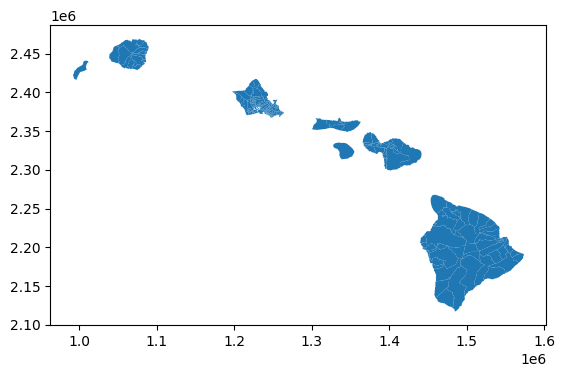

In [70]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()